In [1]:
from matplotlib import pyplot as plt

import numpy as np
import shapely
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from osmnx import features as ox_features
from osmnx import geocode_to_gdf as geocode_to_gdf
from osmnx import projection as ox_projection
from typing import List, Tuple, Dict
import math
from shapely import Point
import random
from sklearn.cluster import KMeans as KM 

from vertiport import Vertiport
#FIX:
# this module will now handle creating objects in/on airspace
# vertiport creation
# restricted airspace creation
#  
class Airspace:
    def __init__(self, number_of_vertiports, location_name: str, buffer_radius: float = 500, airspace_tag_list=[], max_vertiports=25) -> None:   #! airspace feature has to be list of strings
        """Airspace - Defines the location of the map. Imports key information on hopitals(no fly zone)

        Args:
            location_name (string): Location of the Airspace ie. "Austin, Texas, USA"
            buffer_radius (int): distance around hospitals

        Attributes:
            location_name(string): Location of the Airspace ie. "Austin, Texas, USA"
            buffer_radius (int): distance around hospitals
            location_utm_gdf (gdp.GeoDataFrame): Location in UTM(Universal Transverse Mercator)
            location_utm_hospital ( ox_projection): location of hospital converted to UTM
            location_utm_hospital_buffer (UTM): buffer around the hospital
        """
        self.location_name = location_name  #'Austin, Texas, USA'
        self.buffer_radius = buffer_radius
        self.airspace_tag_list = airspace_tag_list

        # location - this is the airspace where we are working 
        location_gdf = geocode_to_gdf(location_name)  # converts named geocode - 'Austin,Texas' location to gdf
        self.location_utm_gdf: gpd.GeoDataFrame = ox_projection.project_gdf(location_gdf)  # default projection - UTM projection #! GeoDataFrame has deprication warning - need quick fix
        self.location_utm_gdf["boundary"] = (self.location_utm_gdf.boundary)  # adding column 'boundary'
        
        # airspace features and restricted airspace 
        self.location_tags = {}
        self.location_feature = {}
        self.location_utm = {}
        self.location_utm_buffer = {}
        
        self.airspace_restricted_area_buffer_array = []
        self.airspace_restricted_area_array = []
        
        for tag, tag_value in self.airspace_tag_list:
            self.location_tags[tag_value] = tag
            self.location_feature[tag_value] = ox_features.features_from_polygon(location_gdf["geometry"][0], tags={tag:tag_value})
            self.location_utm[tag_value] = ox_projection.project_gdf(self.location_feature[tag_value])
            self.location_utm_buffer[tag_value] = self.location_utm[tag_value].buffer(self.buffer_radius)
            self.airspace_restricted_area_array.append(self.location_utm[tag_value])
            self.airspace_restricted_area_buffer_array.append(self.location_utm_buffer[tag_value])
        
        self.restricted_airspace_buffer_geo_series = pd.concat(self.airspace_restricted_area_buffer_array)
        self.restricted_airspace_geo_series = pd.concat(self.airspace_restricted_area_array)


        # Vertiport
        self.number_of_vertiports = number_of_vertiports
        self.vertiport_list:List[Vertiport] = []
        self.max_vertiports = max_vertiports 
        self.polygon_dict = {}

    def __repr__(self) -> str:
        return "Airspace({location_name})".format(location_name=self.location_name)

    def set_vertiport(self,vertiport):
        """
        Adds a vertiport to the vertiport list.

        Args:
            vertiport: The vertiport to add.
        
        Returns:
            None
        """
        if len(self.vertiport_list) < self.max_vertiports:
            self.vertiport_list.append(vertiport)
        else:
            print('Max number of vertiports reached, additonal vertiports will not be added')
        return None 
    
    def get_vertiport_list(self):
        """
        Returns the list of vertiports.

        Returns:
            List: The list of vertiports.
        """
        return self.vertiport_list

    def create_n_random_vertiports(self, num_vertiports: int, seed = None) -> None:
        """
        Creates a specified number of random vertiports within the airspace.

        Args:
            num_vertiports (int): The number of vertiports to create.

        Returns:
            None

        Side Effects:
            - Creates the vertiports and updates the vertiports in the airspace list.
        """

        # Set seed if provided
        if seed is not None:
            print(f"Creating vertiports with seed: {seed}")
            random.seed(seed)
            np.random.seed(seed)

        if num_vertiports > self.number_of_vertiports:
            raise RuntimeError('Exceeds vertiport number defined for initialization')

        for tag_value in self.location_tags.keys():
            sample_space = self.location_utm_gdf.iloc[0,0].difference(
                self.location_utm_buffer[tag_value].unary_union
            )

        sample_space_gdf = GeoSeries(sample_space)
        sample_vertiport: GeoSeries = sample_space_gdf.sample_points(num_vertiports, seed=seed)
        sample_vertiport_array: np.ndarray = shapely.get_parts(sample_vertiport[0])

        for location in sample_vertiport_array:
            self.vertiport_list.append(
                Vertiport(location=location, uav_list=[])
            )

        print(f"Created {len(self.vertiport_list)} vertiports with seed {seed}")

    def create_vertiport_at_location(self, position:Tuple)-> None:
        """Create a vertiport at position(x,y)."""
        position = Point(position[0], position[1])
        
        for tag_value in self.location_tags.keys():
            sample_space = self.location_utm_gdf.iloc[0,0].difference(
                self.location_utm_buffer[tag_value].unary_union
            )

        sample_space_gdf = GeoSeries(sample_space)
        sample_space_array: np.ndarray = shapely.get_parts(sample_space_gdf)

        for sample in sample_space_array:
            if sample.contains(position):
                print('Valid location for vertiport')
                _vertiport = Vertiport(position)
                return _vertiport
        
        print('Not a valid position for vertiport')
        
    
    def create_vertiport_from_polygon(self,polygon:shapely.Polygon) -> Vertiport:
        '''Given a polygon, find the centeroid of the polygon, 
        and place a vertiport at that polygon'''
        poly_centeroid = polygon.centroid
        return Vertiport(poly_centeroid)
        

    def create_vertiports_from_polygons(self,polygon_list:List[shapely.Polygon]) -> List[Vertiport]:
        '''Use polygons from polygon_list to place vertiports at each polygon'''
        vertiport_list = []
        for polygon in polygon_list:
            vertiport_list.append(self.create_vertiport_from_polygon(polygon))
        return vertiport_list
        

    def make_polygon_dict(self, tag_str):
        
        #TODO: check if tag_str in tag_list
        # if True, then use tag_str as key for dict

        self.polygon_dict[tag_str] = [obj for obj in self.location_utm[tag_str].geometry if isinstance(obj, shapely.Polygon)]

        return None 



    def assign_region_to_vertiports(self, vertiport_list:List[Vertiport]) -> List[Vertiport]:
        '''assign regions to each vertioport from vertiport list. '''

        location_tuple = [(vertiport.x, vertiport.y) for vertiport in vertiport_list]

        kmeans = KM(n_clusters=4, random_state=0, n_init="auto").fit(location_tuple)
        
        print(f' These are the labels: {np.unique(kmeans.labels_)}')


        for i in range(len(kmeans.labels_)):
            vertiport = vertiport_list[i]
            vertiport.region = kmeans.labels_[i]

    
        return vertiport_list


    def assign_vertiports_to_regions(self, vertiport_list:List[Vertiport], num_regions:int) -> Dict:

        region_vertiport_dict = {}
        for region_id in range(num_regions):
            region_vertiport_dict[region_id] = []
            for vertiport in vertiport_list:
                if vertiport.region == region_id:
                    region_vertiport_dict[region_id].append(vertiport)
        

        return region_vertiport_dict
                    

    def sample_vertiport_from_region(self, region_dict:Dict, n_sample_from_region:int = 1):
        '''From the dictionary of regions with vertiports, 
        sample "n_sample_from_region" number of vertiports from 
        vertiports list of that region'''

        sampled_vertiports = []
        
        for region in region_dict.keys():
            sampled_vertiports += random.sample(region_dict[region], n_sample_from_region)
        
        return sampled_vertiports




    





    




In [2]:
airspace = Airspace(12,
                    "Austin, Texas, USA",
                    airspace_tag_list=[
                                        ("building", "commercial"),
                                        ("building", "hotel"),
                                        ("building", "residential"),
                                        ("building", "industrial"),
                                        ("building", "office"),
                                        ("building", "retail"),
                                        ("building", "civic"),
                                        ("building", "college"),
                                        ("building", "government"),
                                        ("building", "public"),
                                        ("building", "school"),
                                        ("building", "train_station"),
                                        ("building", "transportation"),
                                        ("building", "university")
                                        ]
)

#step 1
airspace.make_polygon_dict('commercial')
airspace.polygon_dict['commercial']
#step 2
vertiport_list_from_poly = airspace.create_vertiports_from_polygons(airspace.polygon_dict['commercial'])
#step 3
vertiport_with_region = airspace.assign_region_to_vertiports(vertiport_list_from_poly)
print(f'There are a total of {len(vertiport_with_region)} vertiports')

# for vertiport in vertiport_with_region:
#     print(f'Vertiport location {vertiport.location}, belongs to region: {vertiport.region}')

#step 4
regions_dict = airspace.assign_vertiports_to_regions(vertiport_with_region, 4)
    
for region in regions_dict.keys():
    print(f'Region {region} has {len(regions_dict[region])} vertiports')

#step 5
sample_vertiports_from_regions = airspace.sample_vertiport_from_region(regions_dict)

for vertiport in sample_vertiports_from_regions:
    print(f'Vertiport location {vertiport.location} from region {vertiport.region}')
    




/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/set_operations.py:334: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountere

 These are the labels: [0 1 2 3]
There are a total of 503 vertiports
Region 0 has 268 vertiports
Region 1 has 112 vertiports
Region 2 has 66 vertiports
Region 3 has 57 vertiports
Vertiport location POINT (623798.9669021291 3357719.408315556) from region 0
Vertiport location POINT (616983.9559962819 3348692.98979573) from region 1
Vertiport location POINT (617414.1512994347 3338510.5536627844) from region 2
Vertiport location POINT (620722.5169586254 3365364.4662531153) from region 3


/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/set_operations.py:334: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


In [3]:
minx, miny, maxx, maxy = airspace.location_utm_gdf.total_bounds

In [4]:
rangex, rangey = maxx-minx, maxy-miny
rangex, rangey

(36177.49874837778, 46404.09084140975)

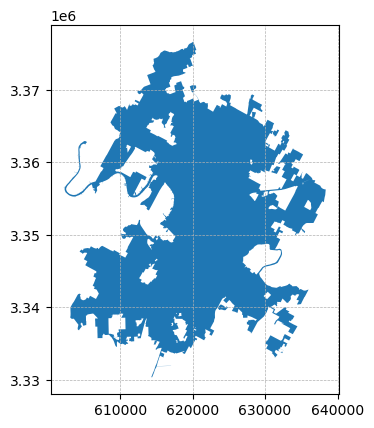

In [5]:
fig, ax = plt.subplots()
airspace.location_utm_gdf.plot(ax=ax)
ax.set_aspect("equal")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [6]:
airspace.location_utm['commercial']

geometry  \
element  id                                                              
node     2532012694                     POINT (623583.936 3348194.789)   
         8303514746                     POINT (623446.433 3358083.294)   
relation 3164465     POLYGON ((619219.815 3366870.996, 619248.379 3...   
         5649602     MULTIPOLYGON (((624702.324 3341958.743, 624711...   
         5691504     POLYGON ((623576.78 3362683.433, 623580.839 33...   
...                                                                ...   
way      1368750718  POLYGON ((627561.021 3361216.747, 627578.118 3...   
         1368750719  POLYGON ((627544.227 3361194.137, 627561.021 3...   
         1368750720  POLYGON ((627530.016 3361175.017, 627544.227 3...   
         1388321146  POLYGON ((616364.371 3339954.034, 616358.979 3...   
         1388834723  POLYGON ((626663.741 3353281.24, 626682.048 33...   

                    addr:city addr:housename addr:housenumber addr:postcode  \
element  id                                                                   
node     2532012694    Austin       Apt 4060             2401         78702   
         8303514746    Austin            NaN             1001         78757   
relation 3164465          NaN            NaN            12424           NaN   
         5649602       Austin            NaN             6800         78741   
         5691504          NaN            NaN              NaN           NaN   
...                       ...            ...              ...           ...   
way      1368750718       NaN            NaN              NaN           NaN   
         1368750719       NaN            NaN              NaN           NaN   
         1368750720    Austin            NaN            11300         78753   
         1388321146       NaN            NaN              NaN           NaN   
         1388834723       NaN            NaN              NaN           NaN   

                            addr:street    building  \
element  id                                           
node     2532012694     East 6th Street  commercial   
         8303514746  West Anderson Lane  commercial   
relation 3164465     Research Boulevard  commercial   
         5649602          Burleson Road  commercial   
         5691504                    NaN  commercial   
...                                 ...         ...   
way      1368750718                 NaN  commercial   
         1368750719                 NaN  commercial   
         1368750720     Wedgewood Drive  commercial   
         1388321146                 NaN  commercial   
         1388834723                 NaN  commercial   

                                                                  name  \
element  id                                                              
node     2532012694                                Vosco Moving Austin   
         8303514746                  Scubaland Adventures North Austin   
relation 3164465     Extended Stay America - Austin - Northwest - R...   
         5649602                           Bergstrom Technology Center   
         5691504                                                   NaN   
...                                                                ...   
way      1368750718                                                NaN   
         1368750719                                                NaN   
         1368750720                                                NaN   
         1388321146                                 Walk! ATX Pet Care   
         1388834723                                     Fluff ‘n’ Buff   

                               phone                           website  ...  \
element  id                                                             ...   
node     2532012694  +1-512-554-4678  http://www.voscomovingaustin.com  ...   
         8303514746  +1-512-323-6999        https://www.scubaland.com/  ...   
relation 3164465                 NaN                               NaN  ... 

In [7]:
is_multipolygon = airspace.location_utm['commercial'].geom_type == "MultiPolygon"
multipolygon = airspace.location_utm['commercial'][is_multipolygon]
type(multipolygon.geometry)
print(multipolygon.geometry[0].centroid)


POINT (624754.2388703752 3341897.6305083837)


/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/geopandas/geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/set_operations.py:334: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountere

TAG VALUE: commercial, 506
TAG VALUE: hotel, 20
TAG VALUE: residential, 165
TAG VALUE: industrial, 124
TAG VALUE: office, 236
TAG VALUE: retail, 640
TAG VALUE: civic, 1
TAG VALUE: college, 24
TAG VALUE: government, 63
TAG VALUE: public, 44
TAG VALUE: school, 456
TAG VALUE: train_station, 1
TAG VALUE: transportation, 2
TAG VALUE: university, 205


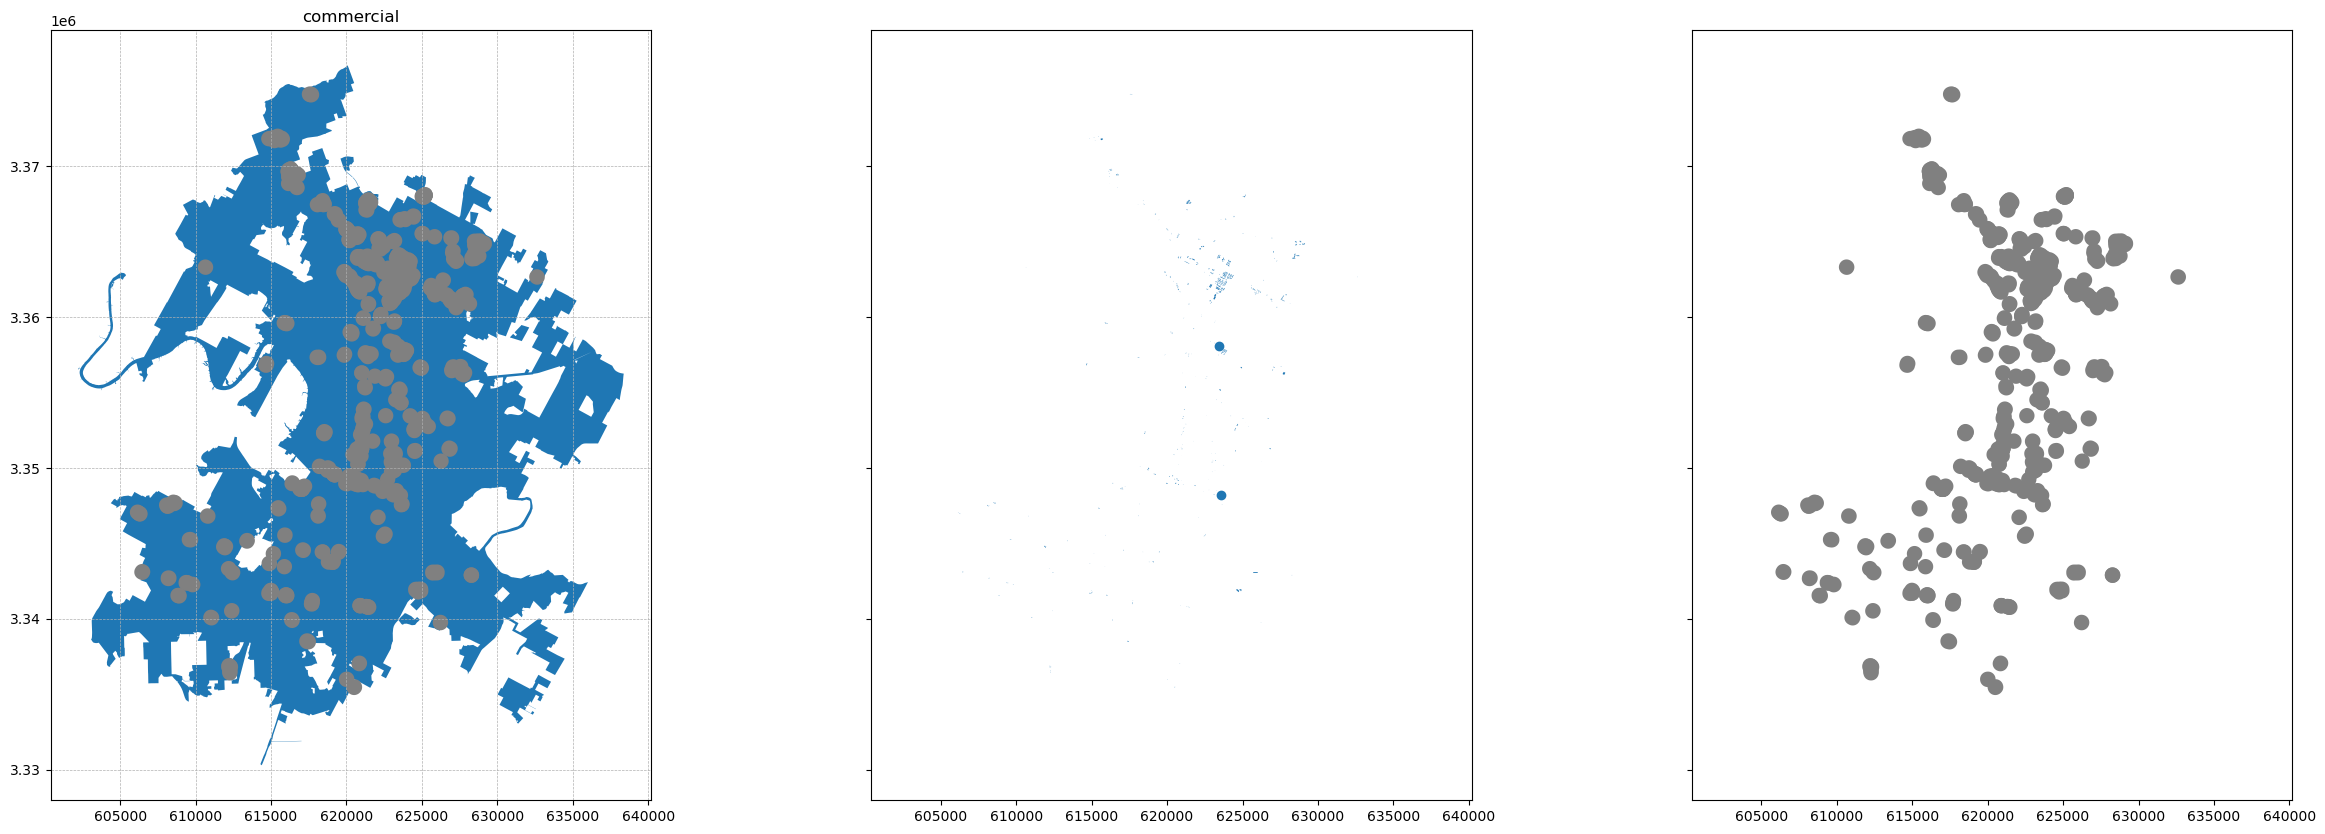

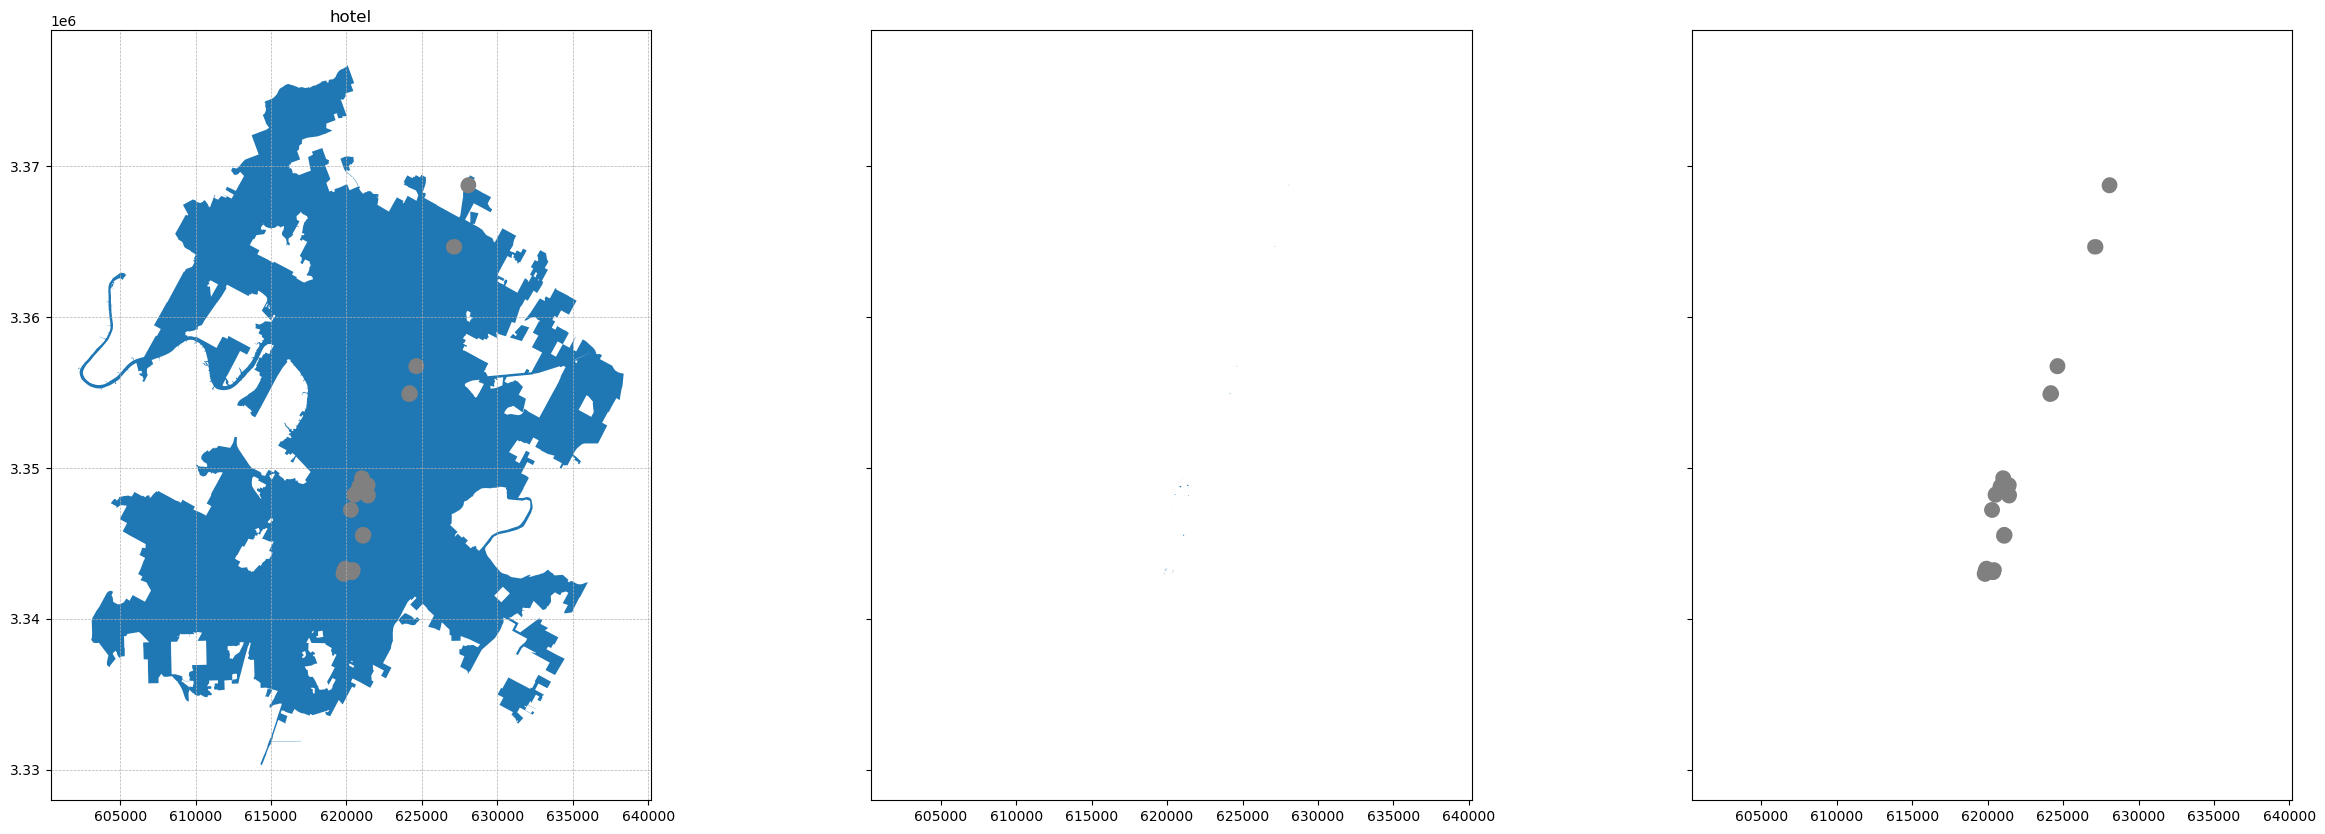

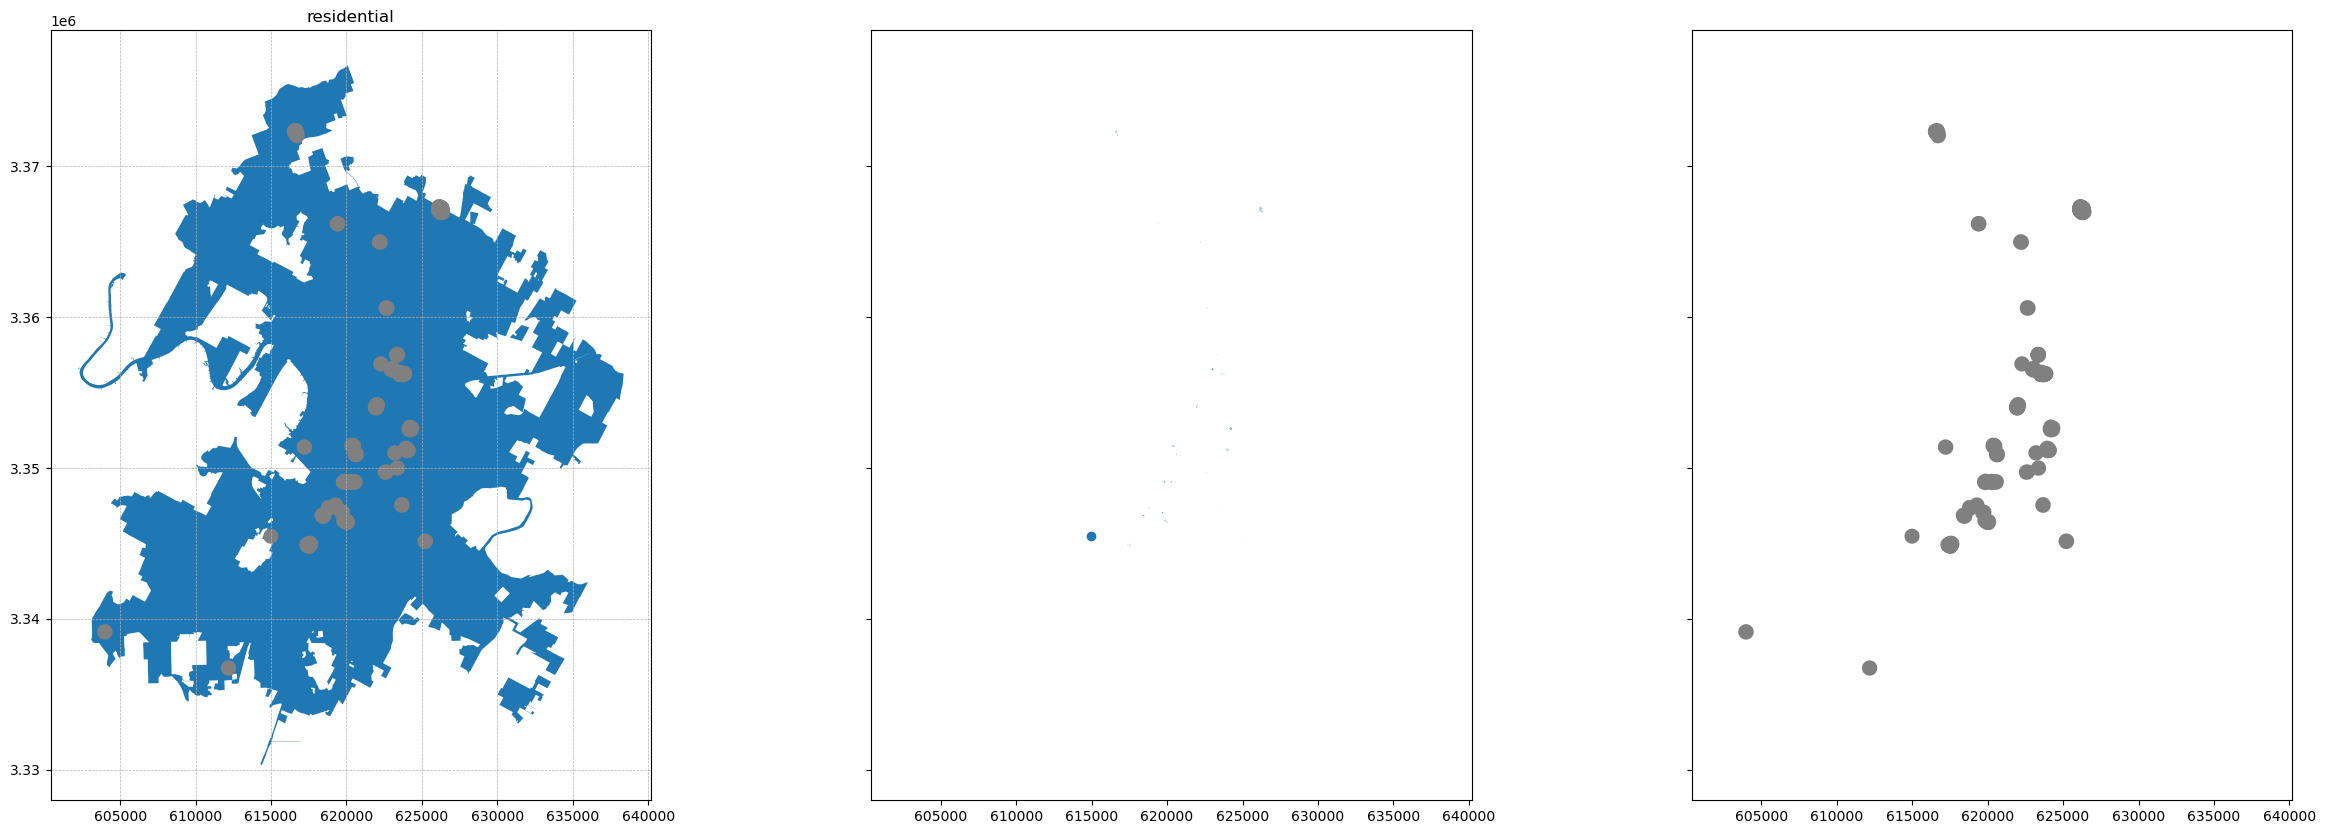

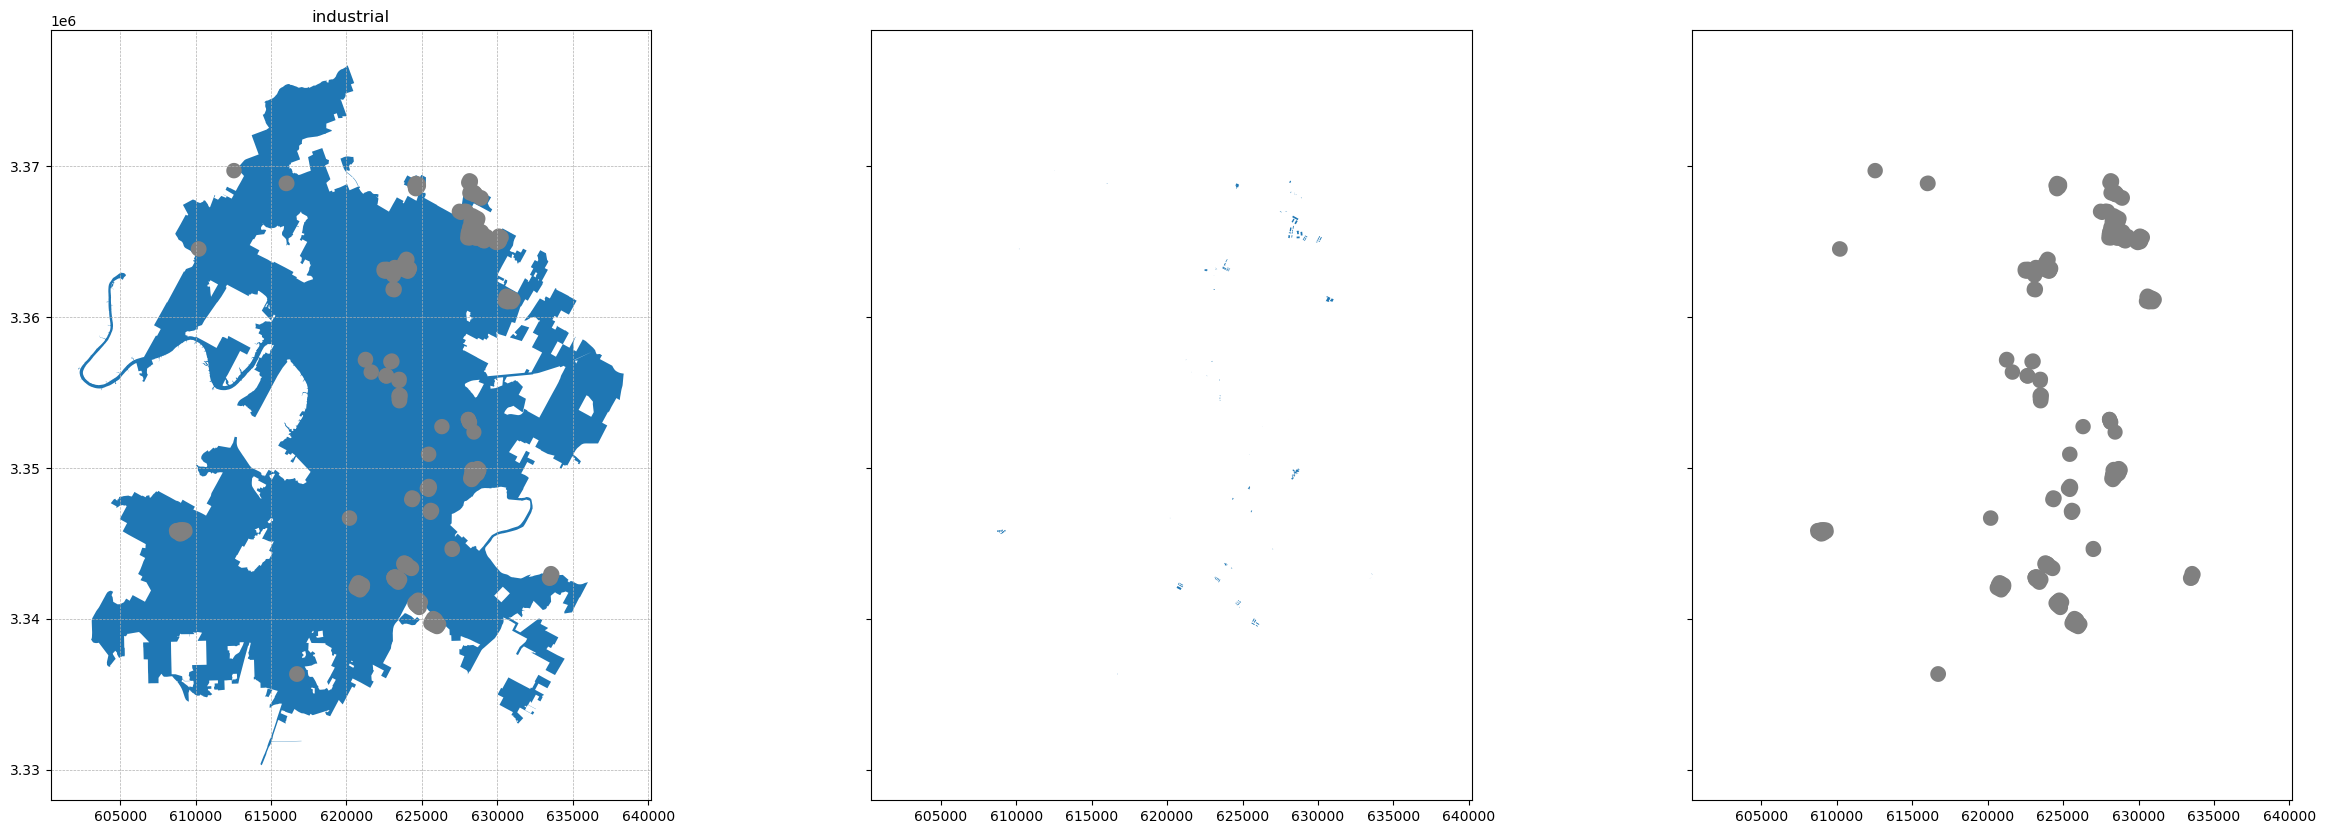

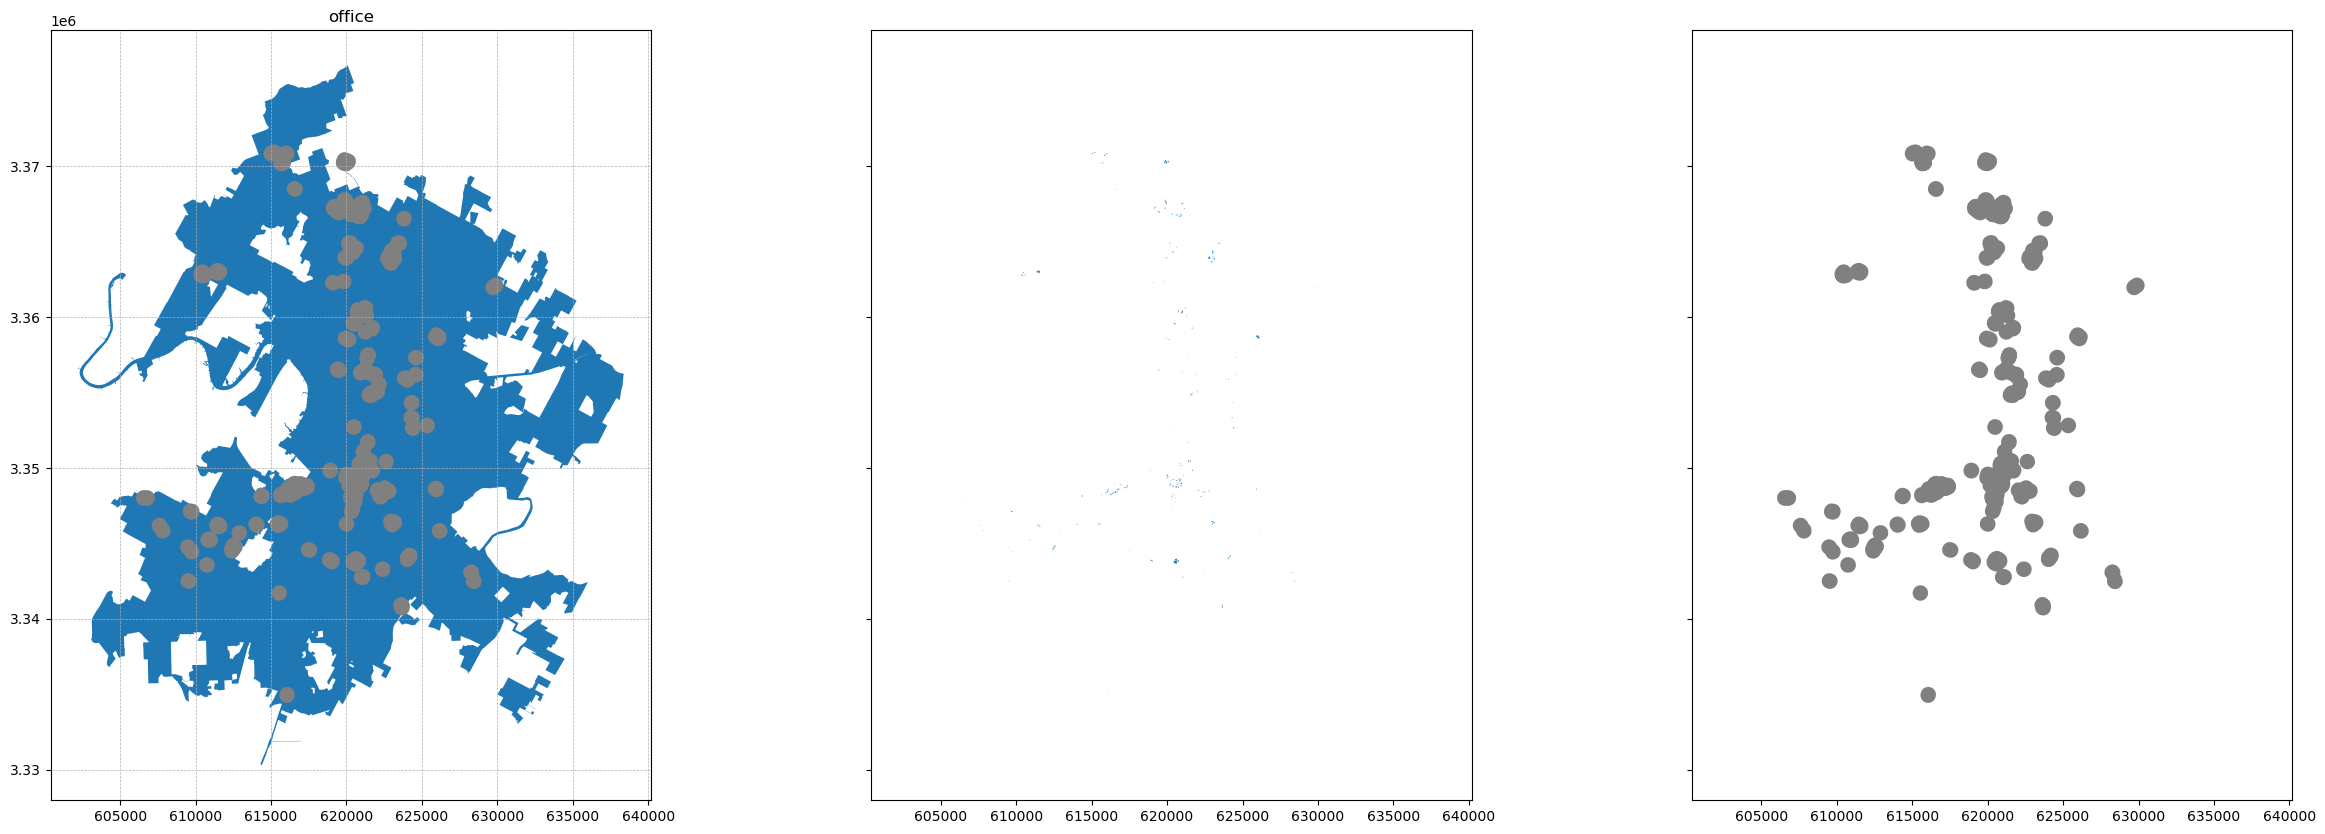

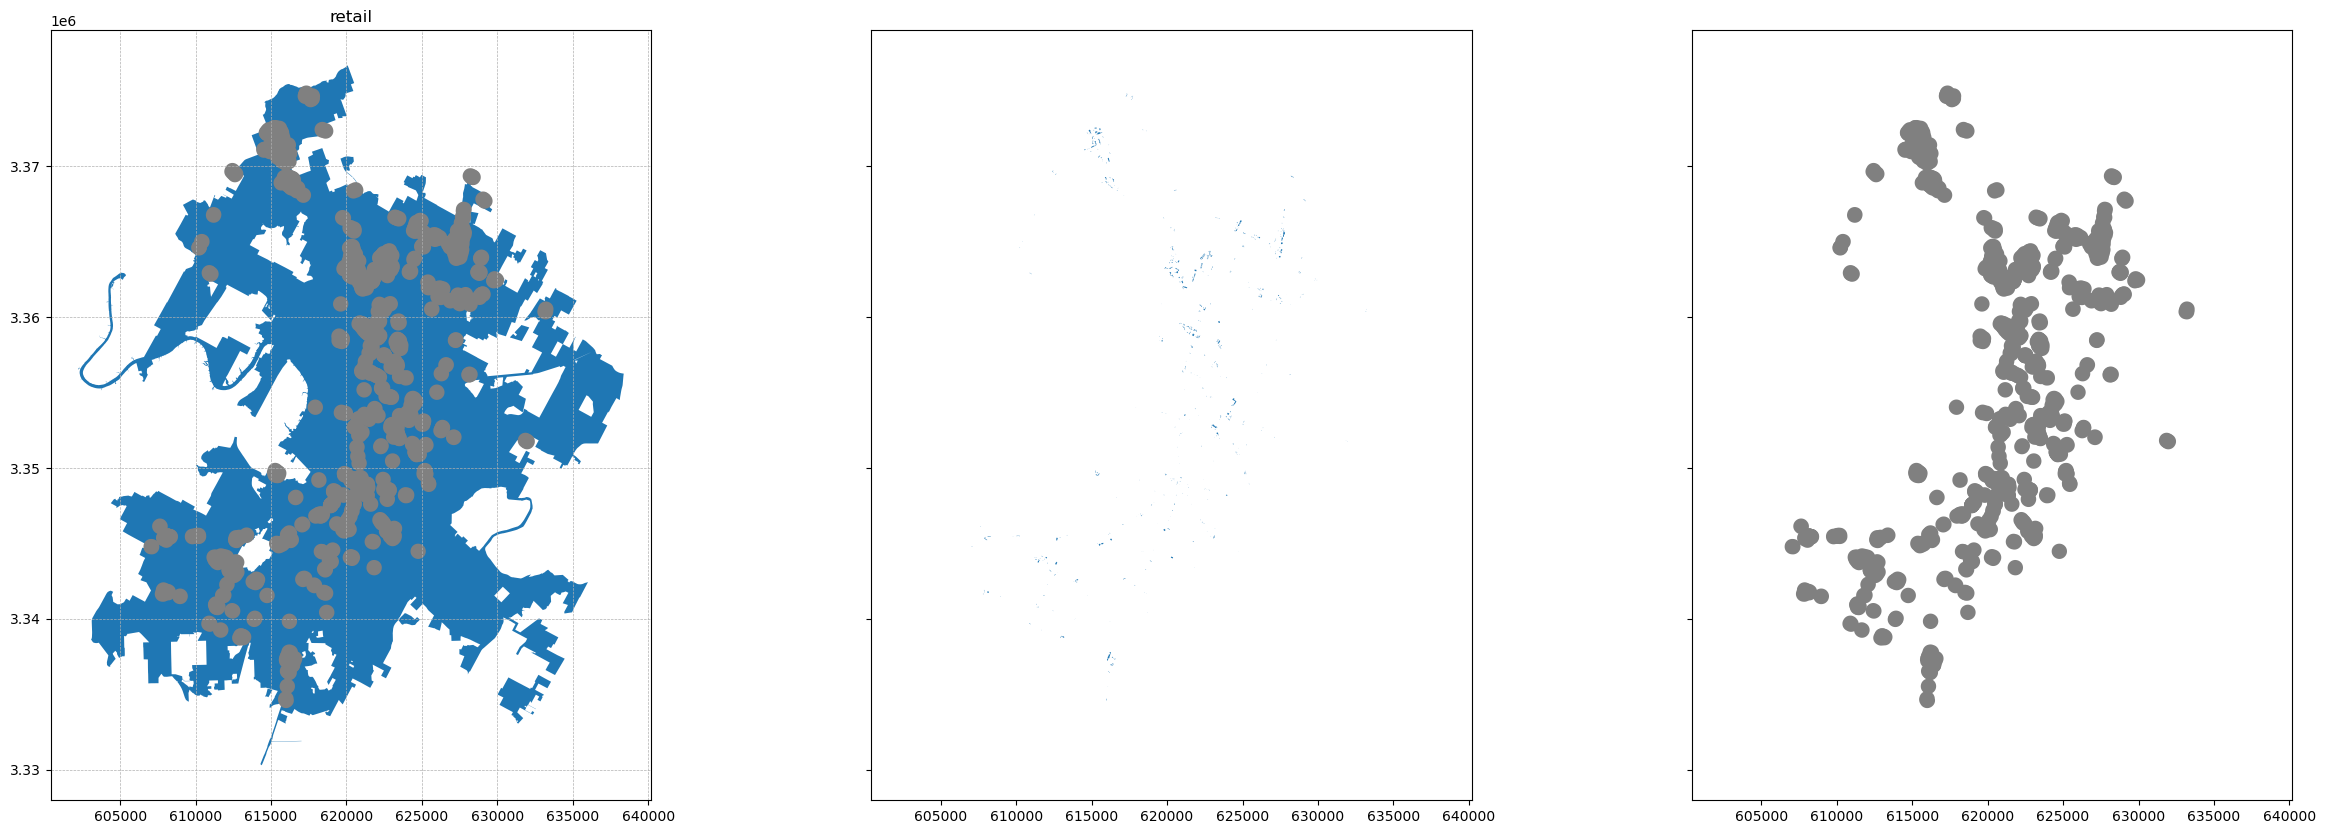

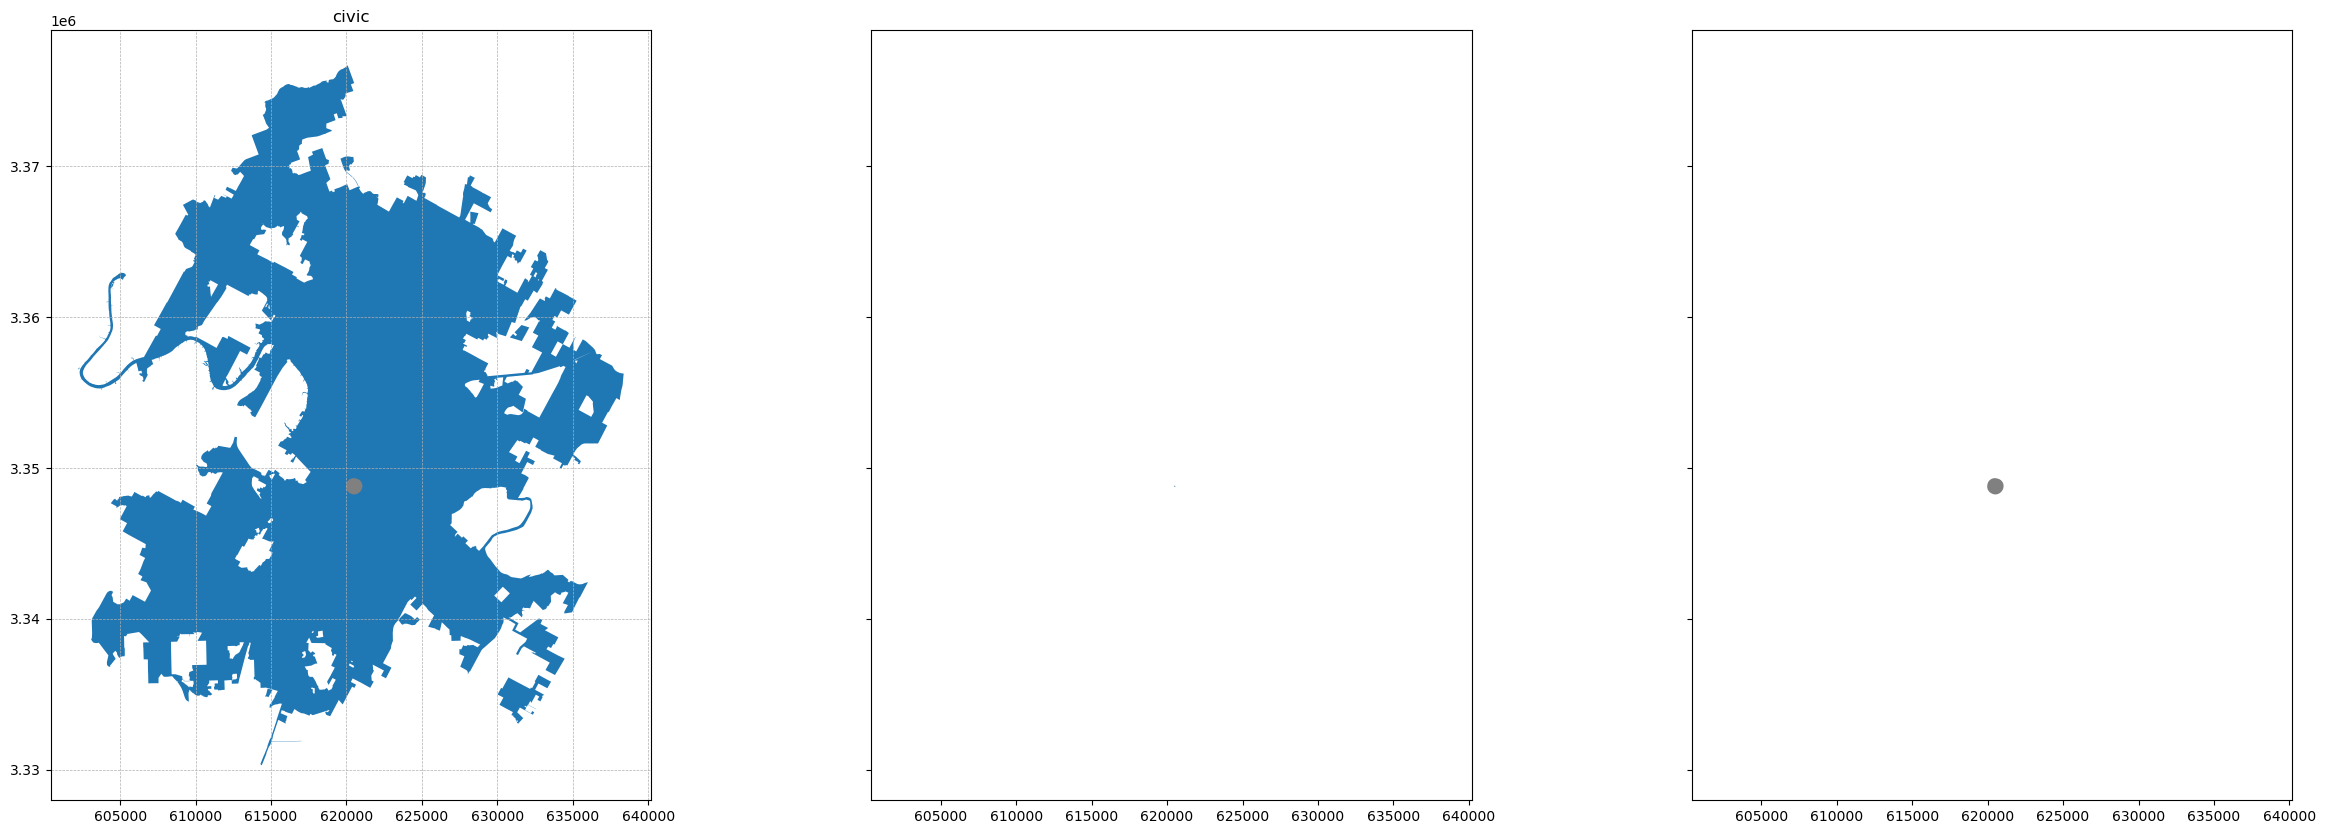

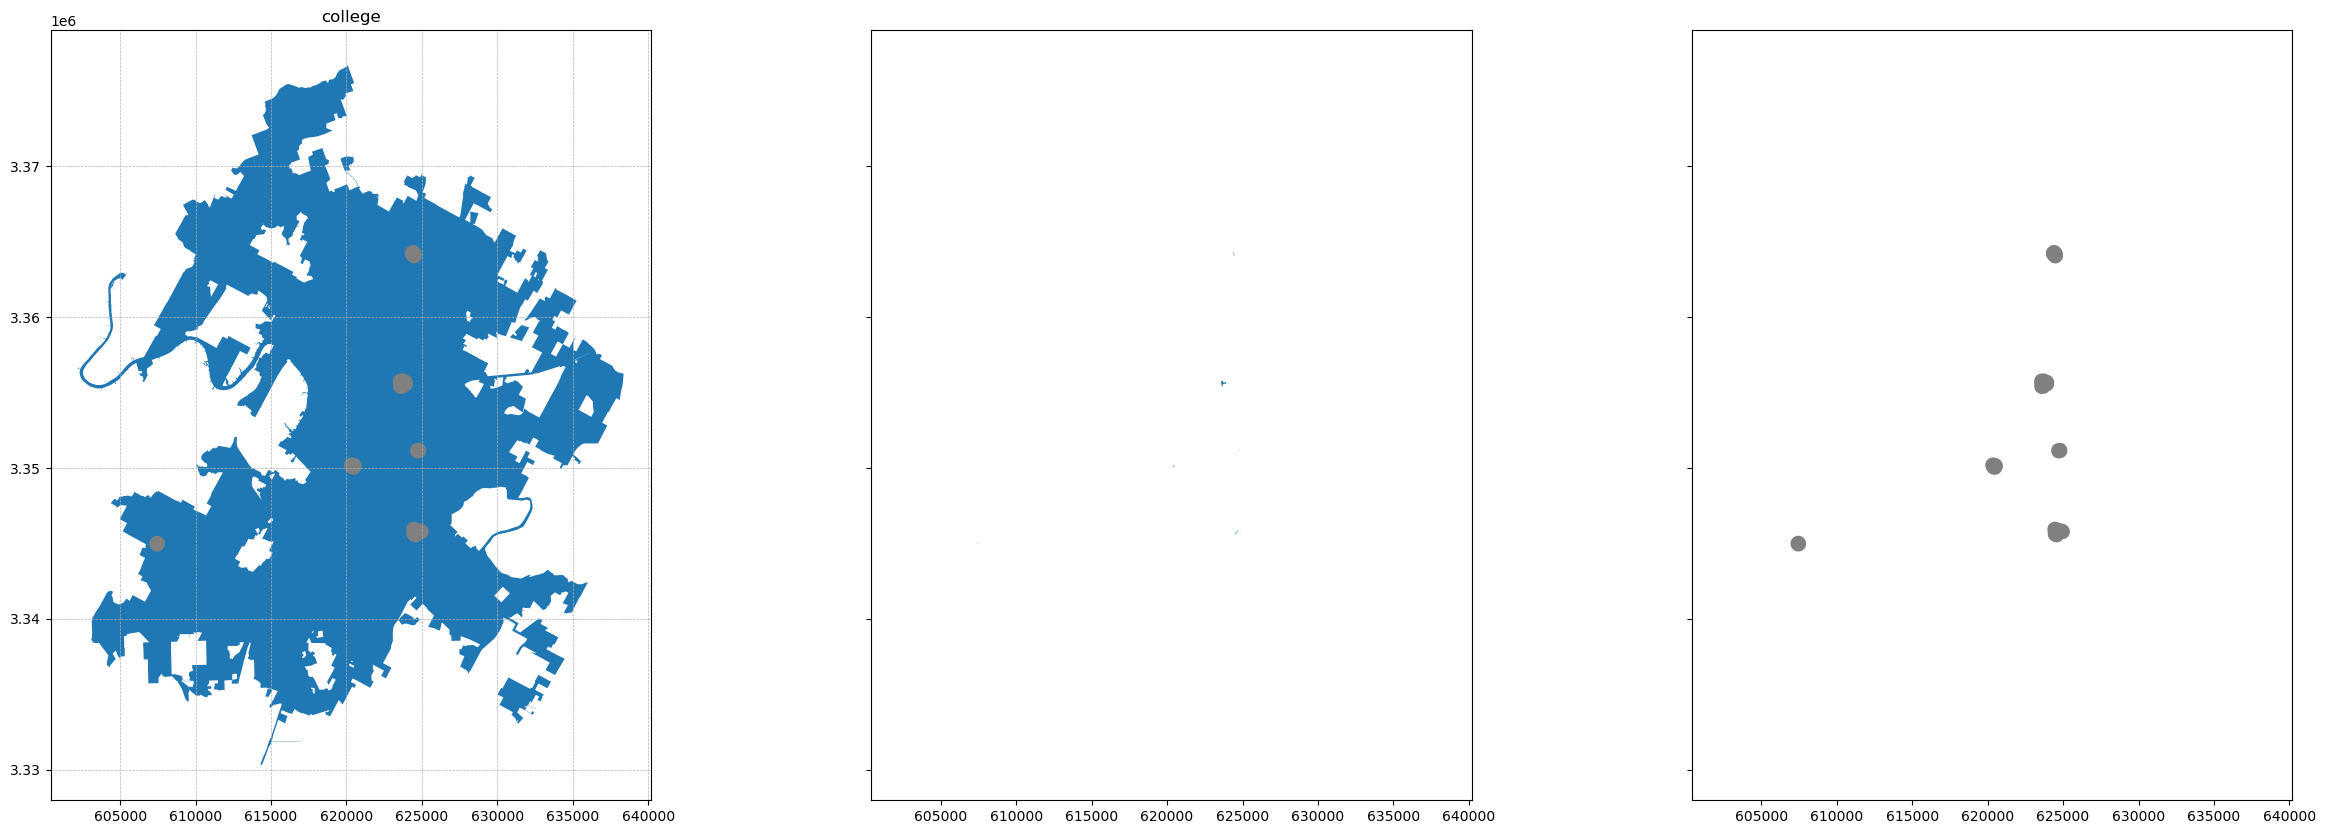

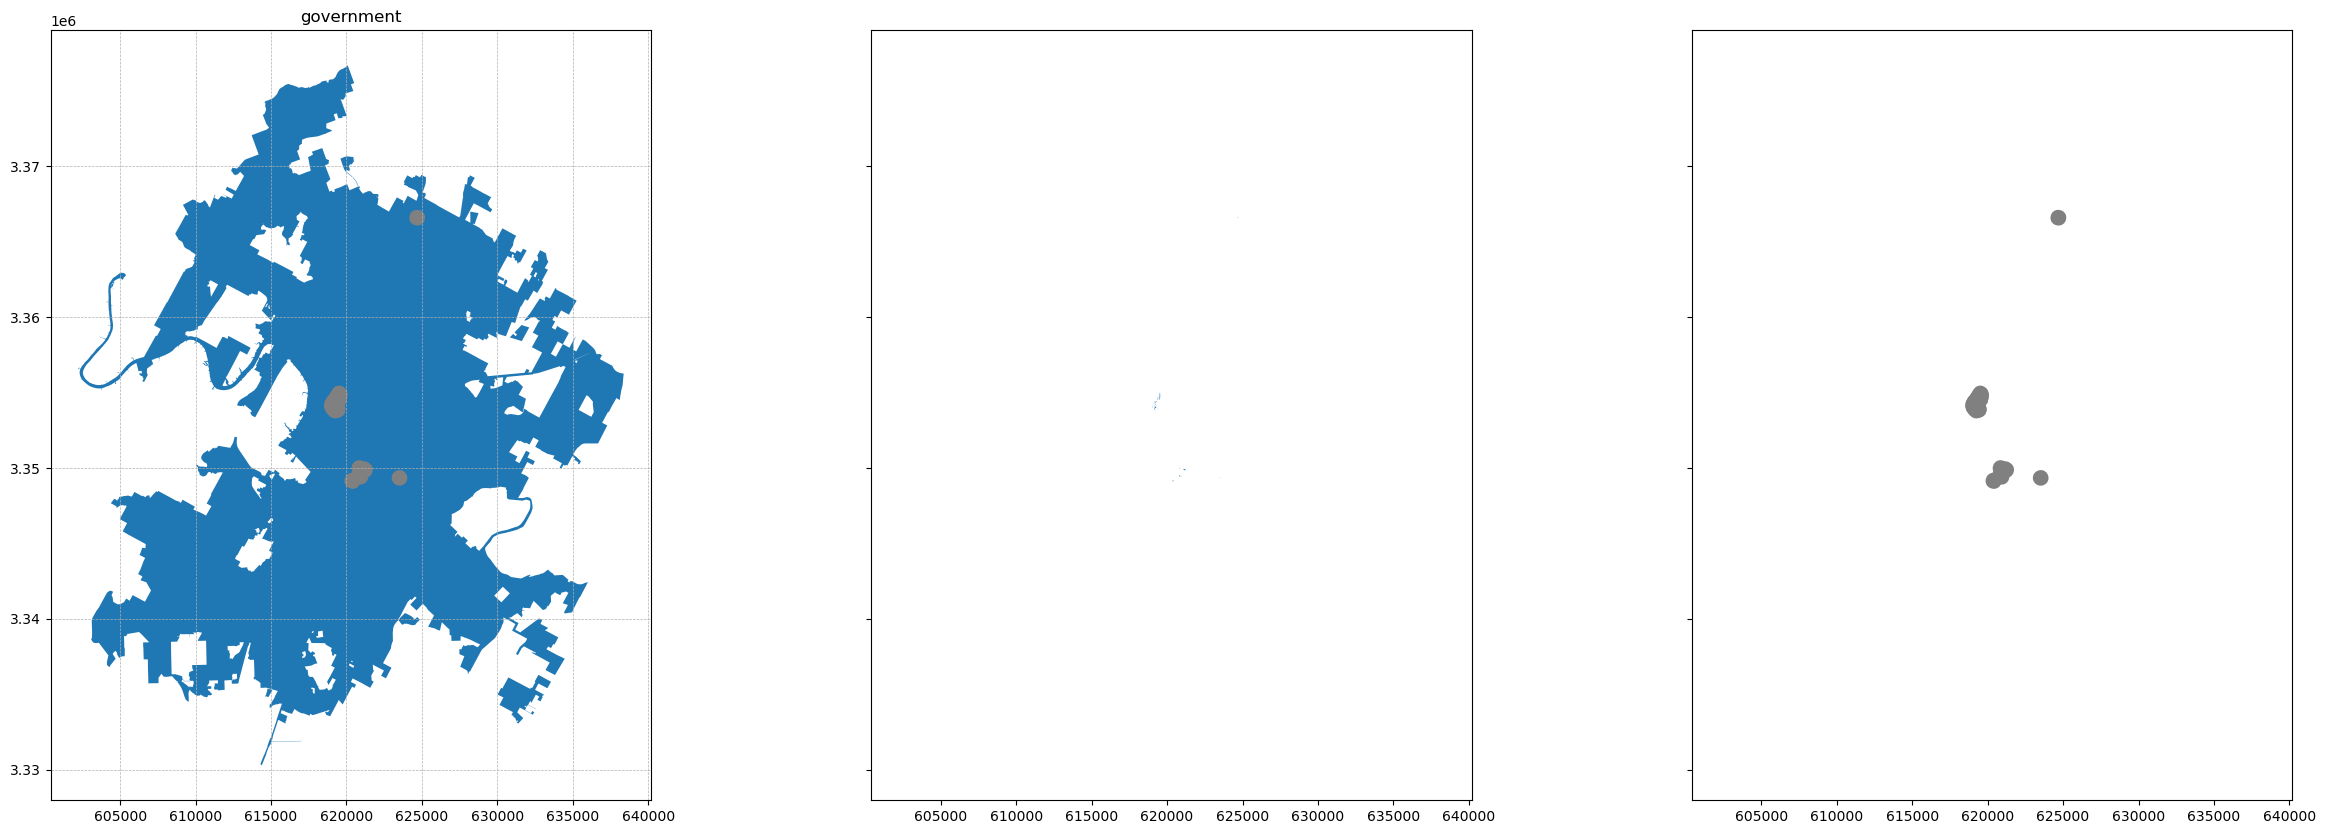

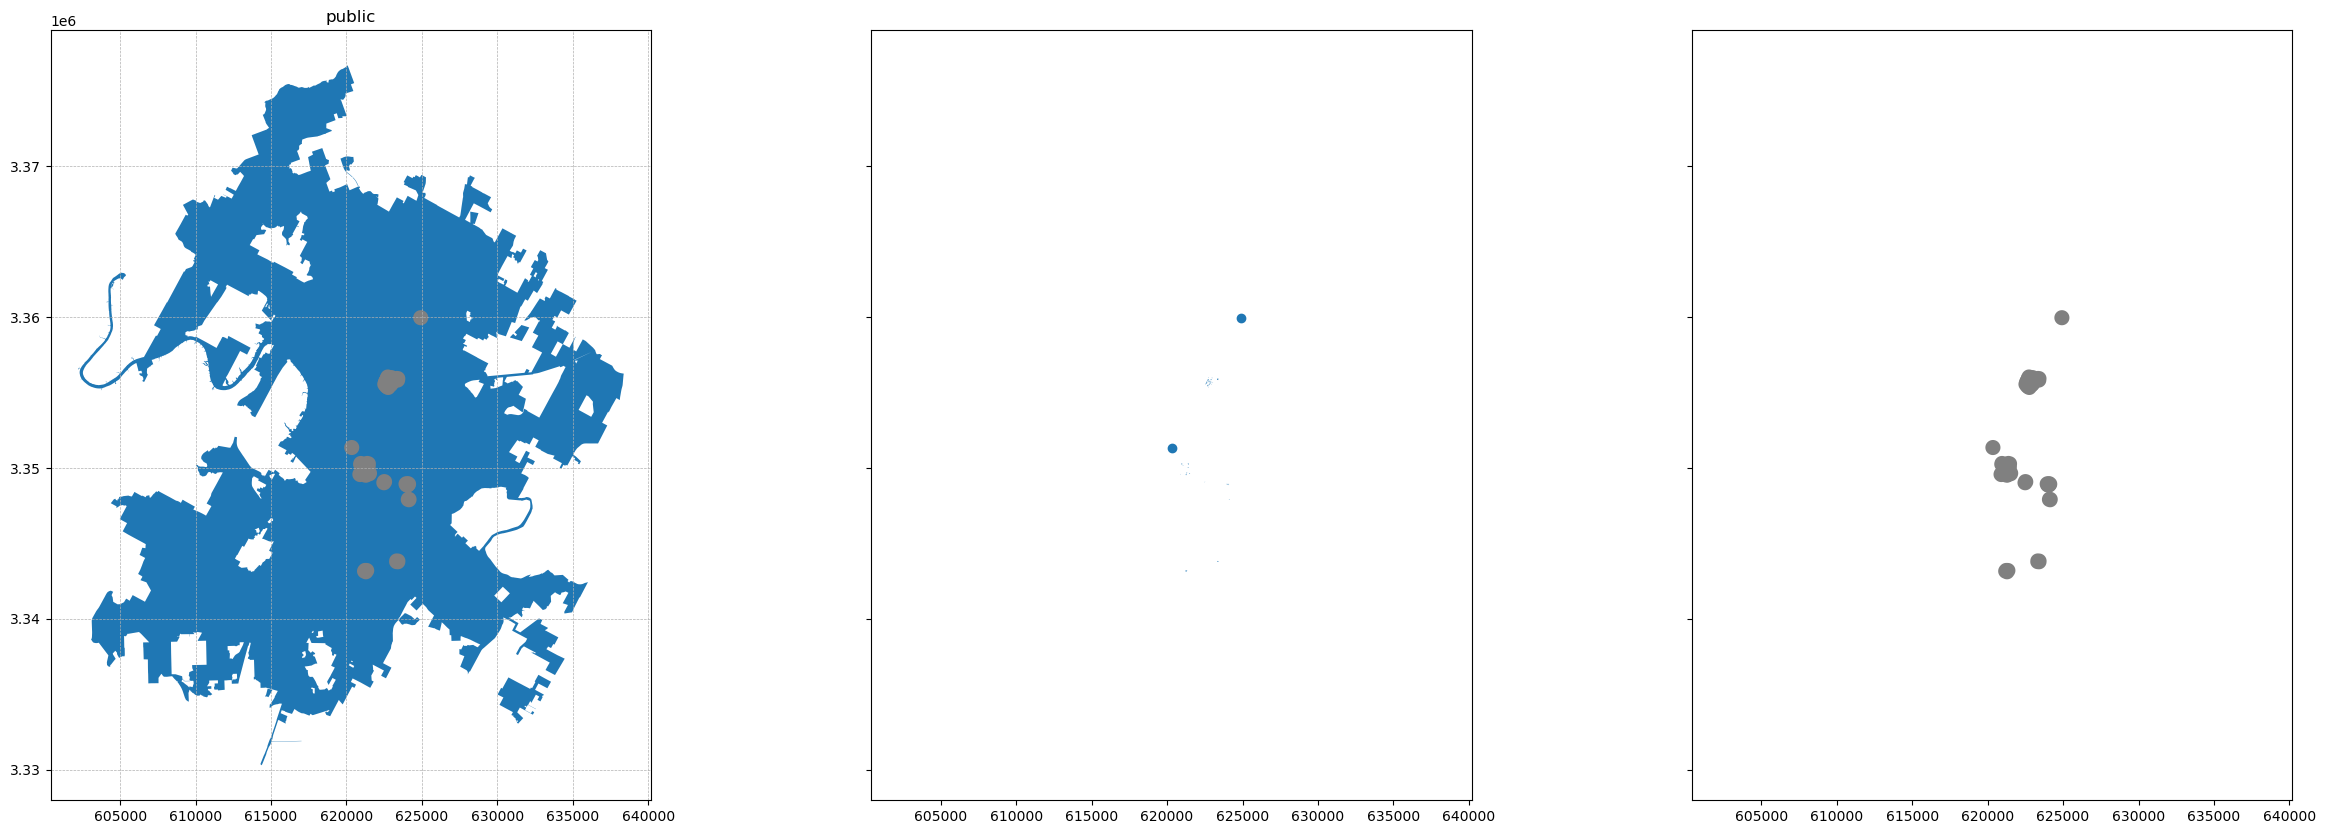

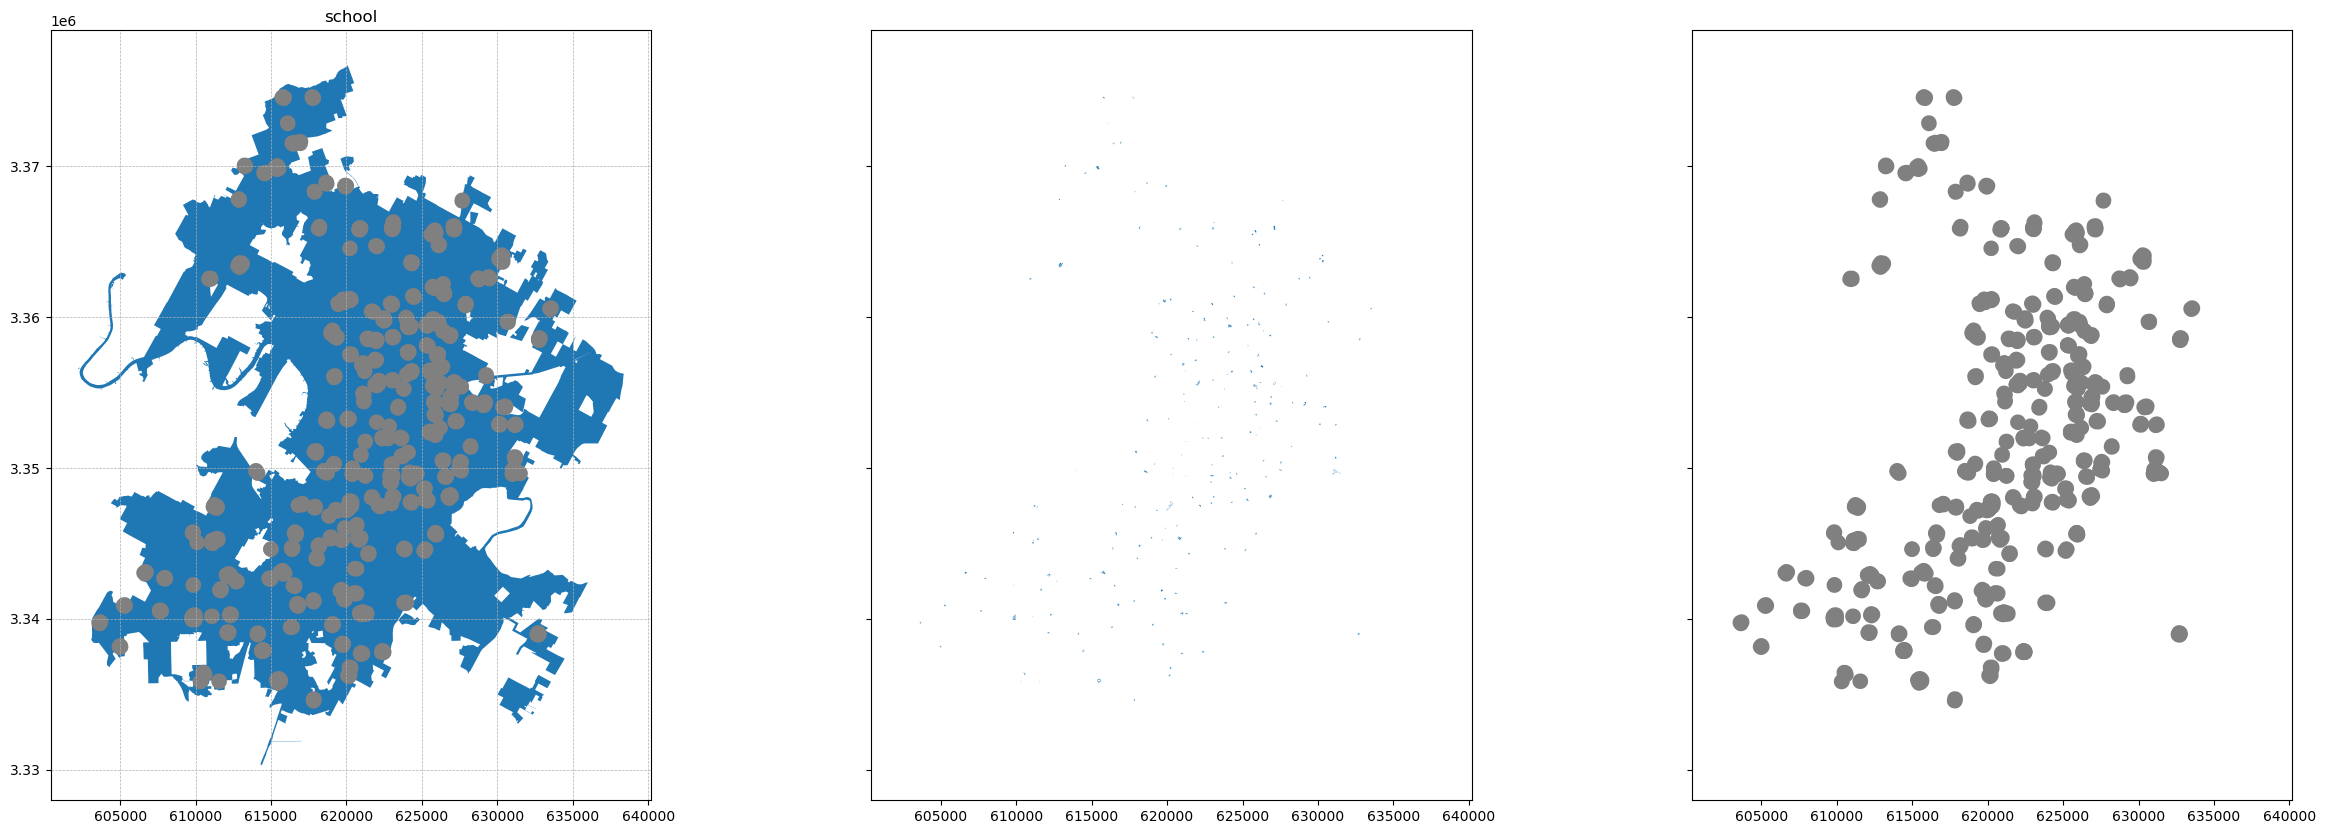

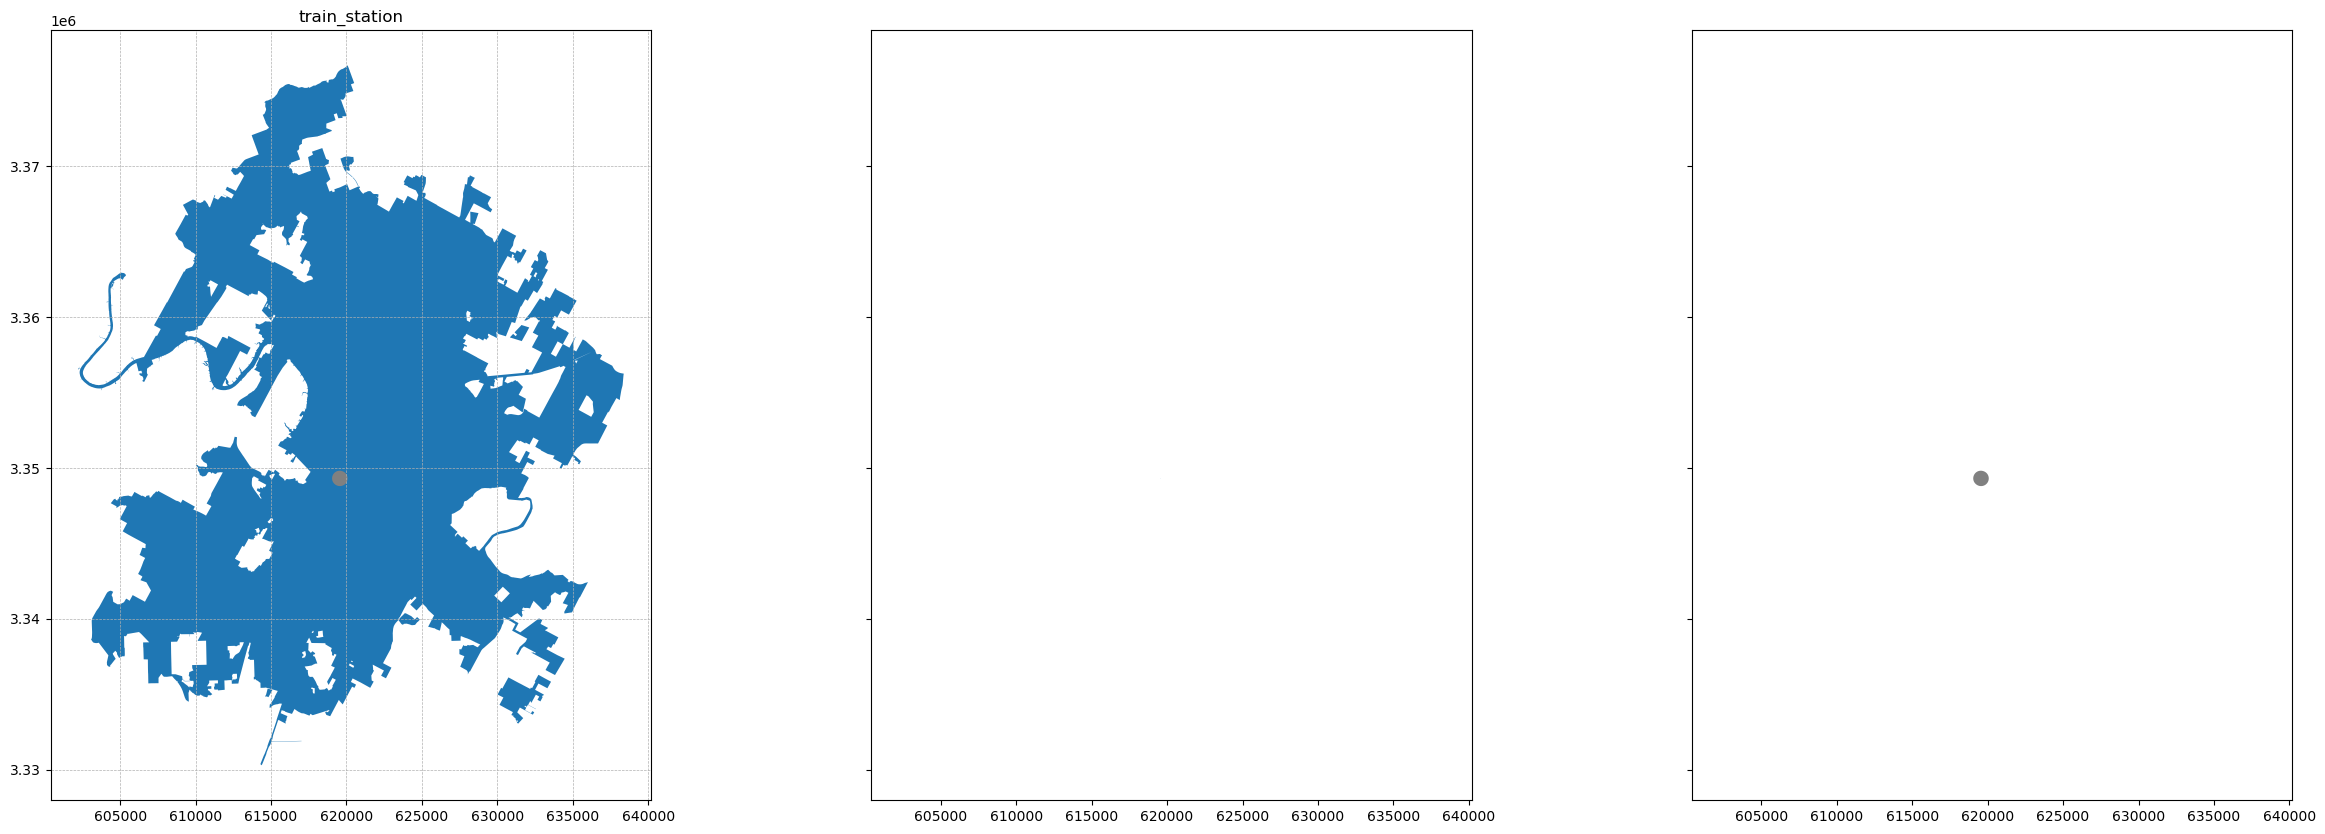

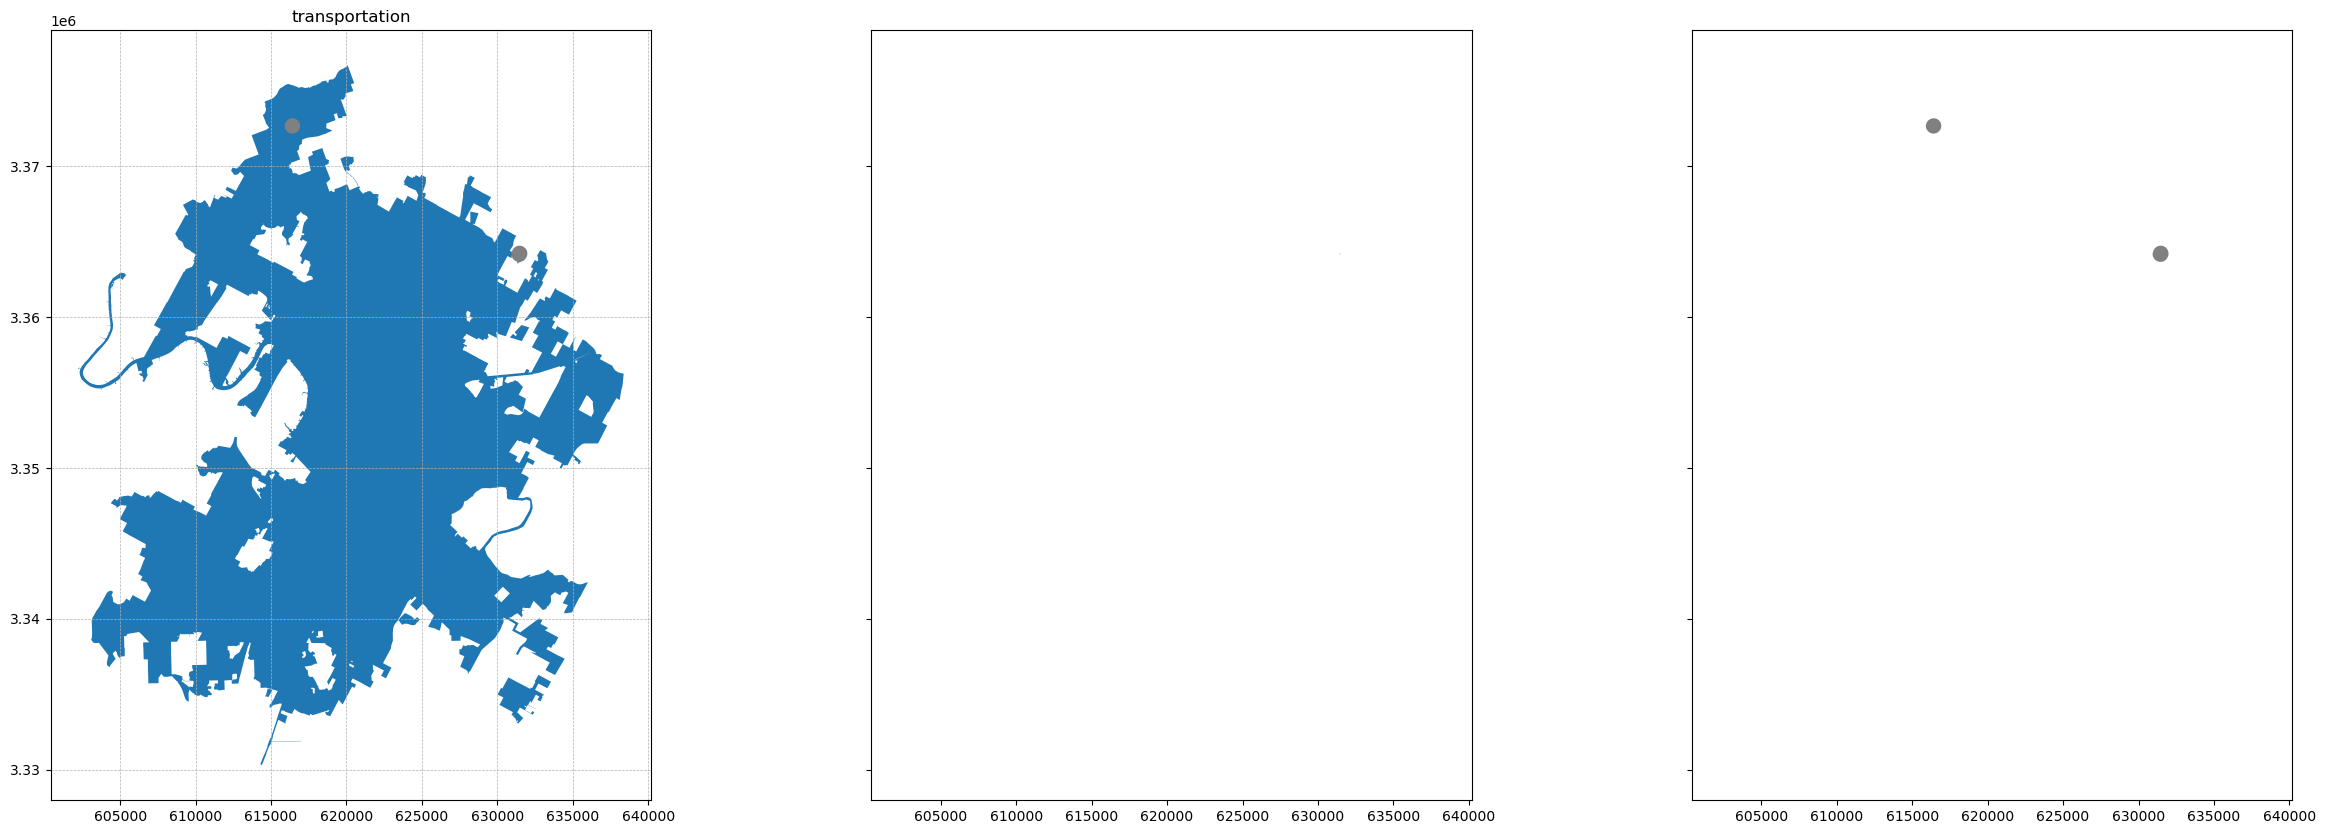

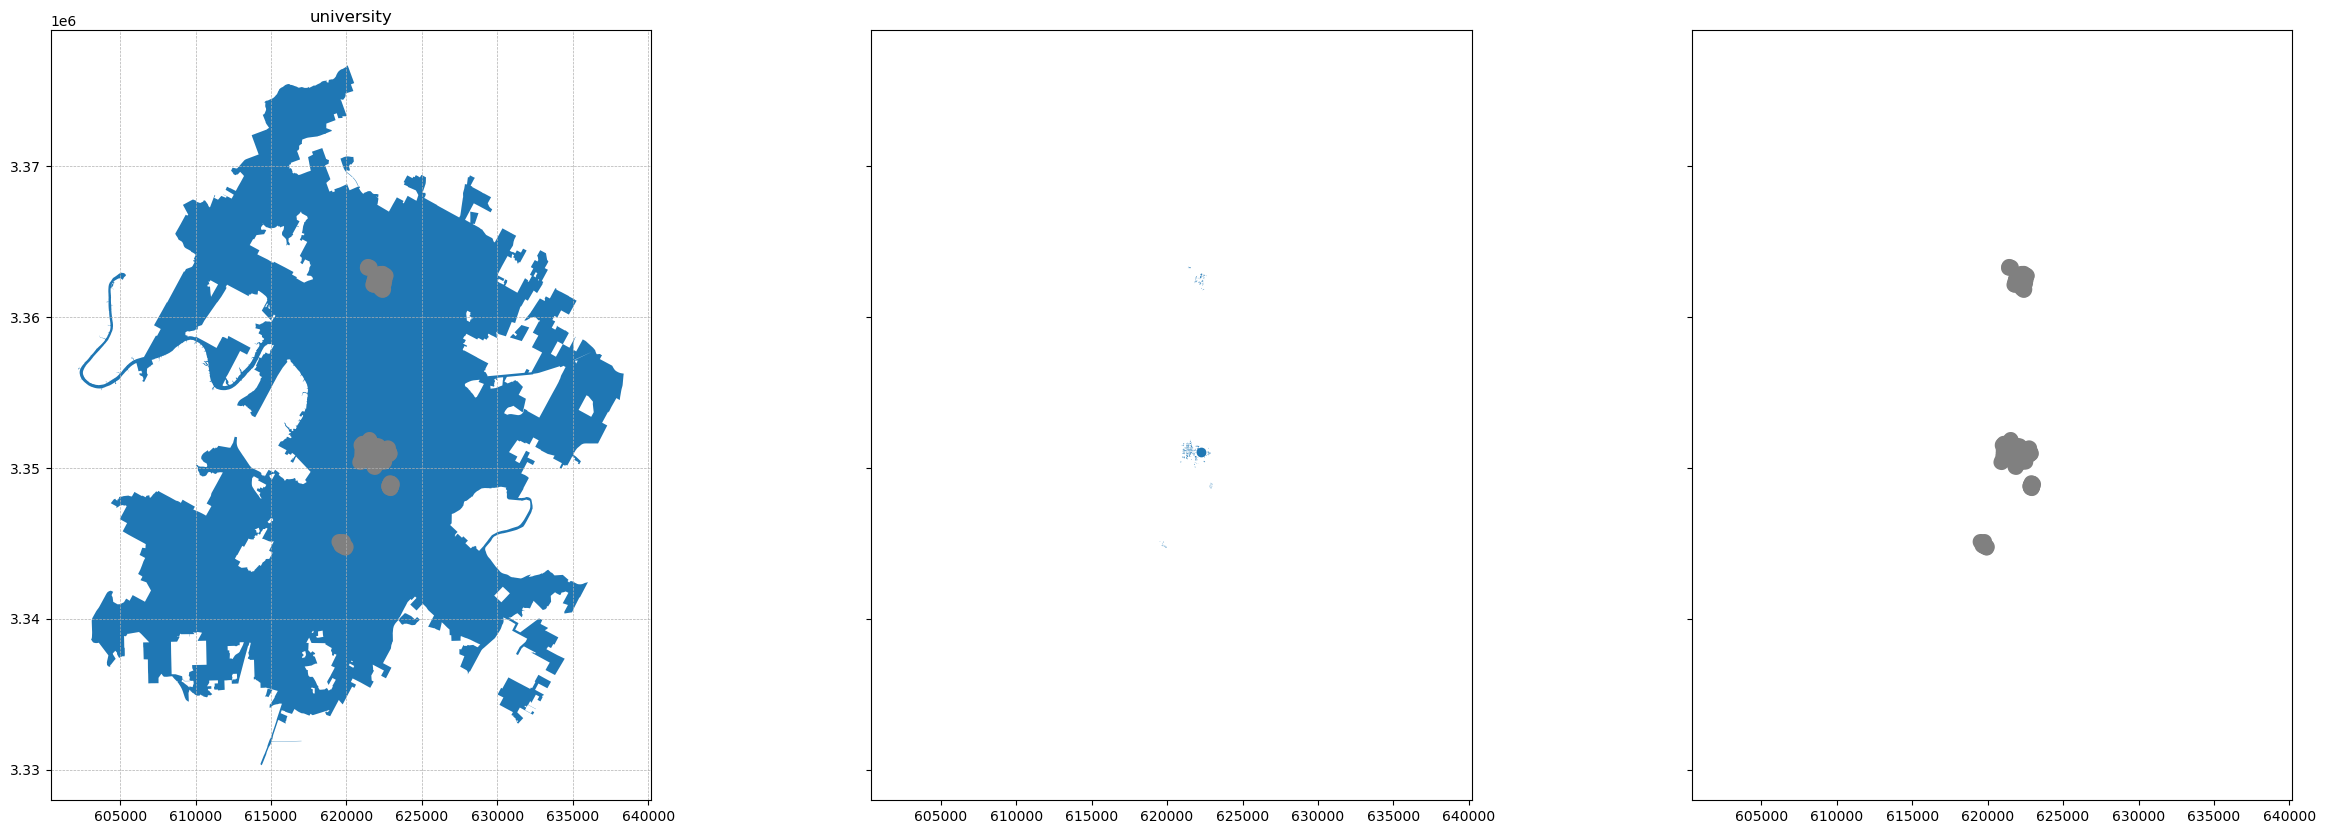

In [8]:
#, ("building", "commercial")
#                                     tag-list:   key, value                                aeroway is a top-level key (aka, top-level tag, feature tag, primary tag)
#                                                                                                       aerodrome is the second level key
# list of primary : secondary keys that are of interest
#        building : apartment
#                 : hotel
#                 : residential
#                 : commercial
#                 : industrial 
#                 : office 
#                 : retail
#                 : supermarket
#                 : civic
#                 : college
#                 : government 
#                 : public 
#                 : school
#                 : train_station
#                 : transportation
#                 : university 
# 
# count the number of polygons for each of the secondary keys 
#airspace = Airspace(12, "Austin, Texas, USA", airspace_tag_list=[("building", "commercial"),  ]) #("building", "hospital"), ("aeroway", "aerodrome"),
airspace = Airspace(12,
                    "Austin, Texas, USA",
                    airspace_tag_list=[
                                        ("building", "commercial"),
                                        ("building", "hotel"),
                                        ("building", "residential"),
                                        ("building", "industrial"),
                                        ("building", "office"),
                                        ("building", "retail"),
                                        ("building", "civic"),
                                        ("building", "college"),
                                        ("building", "government"),
                                        ("building", "public"),
                                        ("building", "school"),
                                        ("building", "train_station"),
                                        ("building", "transportation"),
                                        ("building", "university"),
                                        # ("building", "supermarket"), <- one of the tags which is not valid anymore in OSMNX
                                    ]
)
# airspace.location_utm_gdf.plot()



for tag_value in airspace.location_tags.keys():
            # Draw actual restricted areas
            print(f'TAG VALUE: {tag_value}, {len(airspace.location_utm[tag_value])}')
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True, figsize=(30,10))
            # Austin map
            airspace.location_utm_gdf.plot(ax=ax1)
            ax1.set_title(f'{tag_value}')
            # polygon
            airspace.location_utm[tag_value].plot(ax=ax2)
            # Austin + Buffer
            airspace.location_utm_buffer[tag_value].plot(ax=ax1, color='gray')
            # Buffer 
            airspace.location_utm_buffer[tag_value].plot(ax=ax3, color='gray')

            ax1.set_aspect("equal")
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5)



In [9]:
df_commercial = airspace.location_utm["commercial"]
df_office = airspace.location_utm["office"]

df_commercial['in_df_office'] = df_commercial.geometry.isin(df_office.geometry)

df_commercial['topo_eq_df_office'] = df_commercial.geometry.apply(
    lambda geom: any(geom.equals(other) for other in df_office.geometry)
)

df_commercial['topo_eq_df_office'].any()

False